Step (a): Data Preprocessing

In [40]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [41]:
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)
df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [42]:
df=df.drop(columns=['PassengerId','Name','Ticket','Cabin'],axis=1)

In [43]:
df.isna().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,177
SibSp,0
Parch,0
Fare,0
Embarked,2


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [45]:
df['Age']=df['Age'].fillna(df['Age'].median())

In [46]:
df['Embarked']=df['Embarked'].fillna(df['Embarked'].mode()[0])

In [47]:
num_features=['Age','Fare']

In [48]:
cat_features=['Sex','Embarked','Pclass','SibSp','Parch']

In [49]:
num_pipeline=Pipeline([('imputer',SimpleImputer(strategy='median')),
                        ('scaler',StandardScaler())

                        ])

In [50]:
cat_pipeline=Pipeline([('imputer',SimpleImputer(strategy='most_frequent')),
                       ('encoder',OneHotEncoder(handle_unknown='ignore'))
                       ])

In [51]:
preprocessor=ColumnTransformer([
    ('num',num_pipeline,num_features),
    ('cat',cat_pipeline,cat_features)
])

 Step (b): Feature Engineering (Polynomial Expansions)

In [52]:
from sklearn.preprocessing import PolynomialFeatures

In [53]:
feature_engineering=Pipeline([
    ('preprocess',preprocessor),
    ('poly',PolynomialFeatures(degree=2,include_bias=False))
])

Step (c): Train Models

In [54]:
from sklearn.model_selection import train_test_split

In [56]:
X=df.drop('Survived',axis=1)
y=df['Survived']

In [57]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [58]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier

logreg_model = Pipeline([
    ('features', feature_engineering),
    ('clf', LogisticRegression(max_iter=1000))
])

# SGD Classifier
sgd_model = Pipeline([
    ('features', feature_engineering),
    ('clf', SGDClassifier(loss='log_loss', max_iter=1000))
])

# Ridge Classifier
ridge_model = Pipeline([
    ('features', feature_engineering),
    ('clf', RidgeClassifier())
])

Step (d): Plot Learning Curves

In [63]:
from sklearn.model_selection import GridSearchCV, learning_curve
import numpy as np
import matplotlib.pyplot as plt

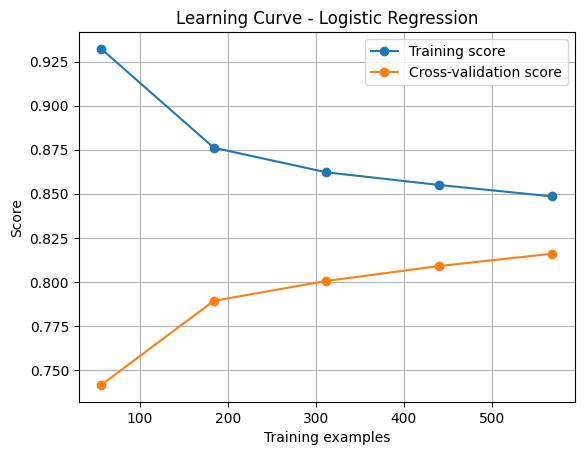

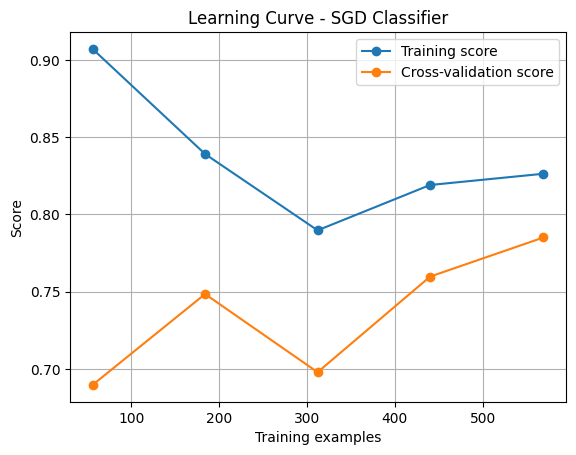

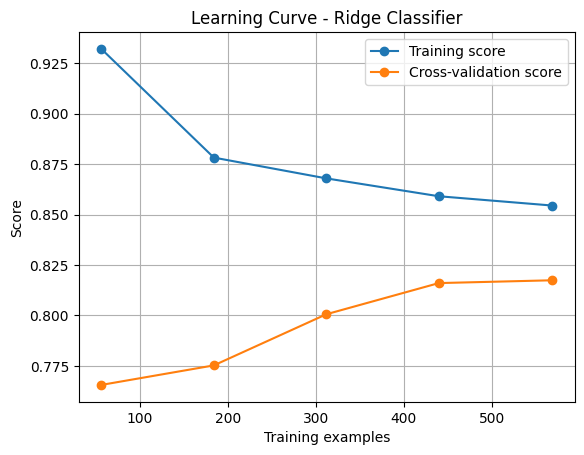

In [62]:

def plot_learning_curve(estimator, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))

    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    plt.figure()
    plt.plot(train_sizes, train_mean, 'o-', label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', label="Cross-validation score")
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Plot for each model
plot_learning_curve(logreg_model, "Learning Curve - Logistic Regression")
plot_learning_curve(sgd_model, "Learning Curve - SGD Classifier")
plot_learning_curve(ridge_model, "Learning Curve - Ridge Classifier")


In [64]:
param_grid = {
    'clf__alpha': [0.1, 1.0, 10.0]
}

grid = GridSearchCV(
    Pipeline([
        ('features', feature_engineering),
        ('clf', SGDClassifier(loss='log_loss'))
    ]),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Score:", grid.best_score_)
print("Test Accuracy:", grid.score(X_test, y_test))


Best Parameters: {'clf__alpha': 0.1}
Best Cross-Validation Score: 0.8075347188023244
Test Accuracy: 0.7932960893854749
